# Summary and Introduction

The aim of this project is to create two reinforcement learning (RL) models which can navigate a robot through a simulated environment to reach one of the two goals without colliding with the walls of the environment. These RL models will have tuned hyper parameters to achieve the best possible convergence and have the highest success rate of reaching the goals. 

During this project the training was unable to achieve convergence regardless of hyper parameters selected or state representation used which will be expanded on and analyzed further below in the report. 

In [1]:
import rclpy as ros
from rclpy.node import Node
from sensor_msgs.msg import LaserScan
import numpy as np
from numpy import Inf
from geometry_msgs.msg import Twist
from nav_msgs.msg  import Odometry
from std_srvs.srv import Empty
import random
from gazebo_msgs.srv import SpawnModel
import random
from math import atan2, pi, atan
import matplotlib.pyplot as plt
import subprocess
import time
ros.init()

In [2]:
class Env(Node):

# initialisation--------------------------------------------------------------
    # frequency: how many often (in seconds) the spin_once is invoked, or the publisher is publishing to the /cmd_vel
    def __init__(self, name='Actions_publisher', 
                 freq=1/20, n=24, 
                 speed=.6, θspeed=pi/2, 
                 rewards=[120, -10, 1, -1],
                 verbose=False):
        super().__init__(name)
        
        self.freq = freq
        self.n = n
        
        self.speed = speed
        self.θspeed = round(θspeed,2)
        
        self.robot = Twist()
        self.rewards = rewards
        self.verbose = verbose

        # do not change----------------------------------------------------
        self.x = 0 # initial x position
        self.y = 0 # initial y position
        self.θ = 0 # initial θ angle
        self.scans = np.zeros(24) # change to how many beams you are using
        self.t = 0
        
        self.tol = .6  # meter from goal as per the requirement (tolerance)
        self.goals =  [[2.0, 2.0], [-2.0, -2.0]]
        # -----------------------------------------------------------------
        
        self.controller = self.create_publisher(Twist, '/cmd_vel', 0)
        self.timer = self.create_timer(self.freq, self.control)

        self.scanner = self.create_subscription( LaserScan, '/scan', self.scan, 0)
        self.odometr = self.create_subscription( Odometry, '/odom', self.odom, 0)
        
        self.range_max = 3.5
        self.range_min = .28               # change as you see fit
        # self.θresol = round(2*pi/8, 2)   # dividing a turning circle into sectors

        # establish a reset client 
        self.reset_world = self.create_client(Empty, '/reset_world')
        while not self.reset_world.wait_for_service(timeout_sec=2.0):
            print('world client service...')


        # compatibility----------------------------------------------
        resol = .3
        θresol = 2*pi/8
        dims = [4,4]
        self.xdim = dims[0]  # realted to the size of the environment
        self.ydim = dims[1]  # realted to the size of the environment
        
        self.resol = round(resol,2)
        self.θresol = round(θresol,2)
        
        self.cols  = int(self.xdim//self.resol) +1   # number of grid columns, related to linear speed
        self.rows  = int(self.ydim//self.resol) +1   # number of grid rows,    related to linear speed
        self.orts  = int(2*pi//self.θresol)     +1   # number of angles,       related to angular speed

        # Set the number of buckets the laser scans will be put into
        self.num_buckets = 3
        self.nF = self.num_buckets * 6 #len(self.scans)
        self.nS = self.num_buckets ** 6
        self.nA = 3

        self.Vstar = None # for compatibility
        # --------------------------------------------------------------- 
        # self.rate = self.create_rate(30)
        self.reset()
        
        print('speed  = ', self.speed)
        print('θspeed = ', self.θspeed)
        print('freq   = ', self.freq)
        print(self.nF)

# sensing--------------------------------------------------------------
    # odometry (position and orientation) readings
    def odom(self, odoms):
        self.x = round(odoms.pose.pose.position.x, 1)
        self.y = round(odoms.pose.pose.position.y, 1)
        self.θ = round(self.yaw(odoms.pose.pose.orientation),2) 
        self.odom = np.array([self.x, self.y, self.θ])
        if self.verbose: print('odom = ',  self.odom )
    
    # laser scanners readings
    def scan(self, scans):
        self.scans = np.array(scans.ranges)
        self.scans[scans==Inf] = self.range_max
        if self.verbose: print('scan = ', self.scans[:10].round(2))
        
    # converting to the quaternion self.z to Euler
    # see https://www.allaboutcircuits.com/technical-articles/dont-get-lost-in-deep-space-understanding-quaternions/#
    # see https://eater.net/quaternions/video/intro
    
    def yaw(self, orient):
        x, y, z, w = orient.x, orient.y, orient.z, orient.w
        yaw = atan2(2.0*(x*y + w*z), w*w + x*x - y*y - z*z)
        return yaw if yaw>0 else yaw + 2*pi # in radians, [0, 2pi]
    
    # angular distance of robot to a goal.............................................
    def θgoal(self, goal):
        xgoal, ygoal = self.goals[goal] 
        x, y  = self.x, self.y
        θgoal = atan2(abs(xgoal-x), abs(ygoal-y)) # anglegoal
        # if θgoal<=0  θgoal += 2*pi
        return round(θgoal, 2) # in radians, [0, 2pi]
    
    # Eucleadian distance of robot to nearest goal......................................   
    def distgoal(self):
        dists = [Inf, Inf]        # distances of robot to the two goals
        for goal, (xgoal, ygoal) in enumerate(self.goals):
            dists[goal] = (self.x - xgoal)**2 + (self.y - ygoal)**2
            
        dist = min(dists)         # nearest goal distance
        goal = dists.index(dist)  # nearest goal index
        
        if self.verbose: print('seeking goal ____________________', goal)
        return round(dist**.5, 2), goal
    
    # robot reached goal ...............................................................
    def atgoal(self):
        tol, x, y = self.tol,  self.x, self.y
        atgoal = False
        for xgoal, ygoal in self.goals:
            atgoal = xgoal + tol > x > xgoal - tol  and  \
                     ygoal + tol > y > ygoal - tol
            
            if atgoal: print('Goal has been reached woohoooooooooooooooooooooooooooooo!!'); break
        return atgoal

    # robot hits a wall...................................................................
    def atwall(self, rng=4):
        # check only 2*rng front scans for collision, given the robot does not move backward
        return np.r_[self.scans[-rng:], self.scans[:rng]].min() < self.range_min 
        #return self.scans.min()<self.range_min
        
    # reward function to produce a suitable policy..........................................
    def reward(self, a, imp=2):
        stype = [self.atgoal(), self.atwall(), a==1, a!=1].index(True)
                
        dist, goal = self.distgoal()
        θgoal = self.θgoal(goal)

        # get angular distance to reward/penalise robot relative to its orientation towards a goal
        θdist = abs(self.θ - θgoal)
        if goal==1: θdist -= pi
        θdist = round(abs(θdist),2)

        reward = self.rewards[stype] 
        if stype: reward -= imp*(dist+θdist) 
        
        if self.verbose: 
            print('reward components=', 
                  'Total reward=', reward, 
                  'state reward=', self.rewards[stype],
                  'goal dist=', dist, 
                  '|θ-θgoal|=', θdist)
                #   'θrobot=', self.θ, 
                #   'θgoal =', θgoal, 
        
        # reset without restarting an episode if the robot hits a wall
        if stype==1: self.reset() 

        return reward, stype==0, stype==1

# State representation-------------------------------------------------
   # change this to generate a suitable state representation
    def s(self):
        scan_data = np.around(np.array(self.scans), decimals=2)
        # scan_data = (scan_data - self.range_min) / (self.range_max - self.range_min) * (1 - 0) + 0

        return np.ravel(scan_data)
    
    # initial state attempt using normalized laserscan inputs as the state
    #def s_(self):
        #scans, range_max = self.scans, self.range_max
        #normalized_scans = np.clip(scans, 0, range_max) / range_max

        #normalized_scans = np.concatenate(normalized_scans[:3], normalized_scans[-3:])

        #state = np.array(normalized_scans).flatten()
            
        #return state/state.sum()


    # second state attempt using raw laserscan inputs as the state
    #def s_(self):
        #nF, scans, range_max = self.nF, self.scans, self.range_max
        #φ = np.r_[scans[-nF//2:], scans[:nF//2]]
        #φ[φ==Inf] = range_max
        #return φ/φ.sum()
    
    # third state attempt using buckets for containing states within a certain range to decrease the total state count
    def s_(self):
        first_three = self.scans[:3]
        last_three = self.scans[-3:]
        scans = np.r_[first_three, last_three]
        inputs = len(scans)
        encoded_data = np.zeros((inputs, self.num_buckets), dtype=int)
        for i, input_val in enumerate(scans):
            if np.isinf(input_val):
                input_val = self.range_max
            bucket_index = min(int(input_val * self.num_buckets), self.num_buckets - 1)
            encoded_data[i, bucket_index] = 1

        encoded_data = encoded_data.flatten()

        return encoded_data/encoded_data.sum()
    

    
    def S_(self):
        return np.eye(self.nF)


# Control--------------------------------------------------------------    
    def spin_n(self, n):
        for _ in range(n): ros.spin_once(self)
            
    def control(self): 
        self.controller.publish(self.robot) 
        
    # move then stop to get a defined action
    def step(self, a=1, speed=None, θspeed=None):
        if speed is None: speed = self.speed
        if θspeed is None: θspeed = self.θspeed

        self.t +=1
        if self.verbose: print('step = ', self.t)
        
        if  a==-1: self.robot.linear.x  = -speed  # backwards
        elif a==1: self.robot.linear.x  =  speed  # forwards
        elif a==0: self.robot.angular.z =  θspeed # turn left
        elif a==2: self.robot.angular.z = -θspeed # turn right

        # Now move and stop so that we can have a well defined actions  
        self.spin_n(self.n) if a==1 else self.spin_n(self.n//2)
        self.stop()

        reward, done, wall = self.reward(a)
        return self.s_(), reward, done, {}
        
    def stop(self):
        self.robot.linear.x = .0
        self.robot.angular.z = .0
        #  spin less so that we have smoother actions
        self.spin_n(self.n//8)

# reseting--------------------------------------------------------------
    def reset(self):
        print('resetting world..........................................')
        # to ensure earlier queued actions are flushed, there are better ways to do this
        for _ in range(1): self.reset_world.call_async(Empty.Request())
        for _ in range(2): self.step(a=1, speed=0.00001)  # move slightly forward to update the odometry to prevent repeating an episode unnecessary
        while abs(self.robot.linear.x) > 0.02:
            time.sleep(0.2)
        for _ in range(1): self.reset_world.call_async(Empty.Request())

        time.sleep(0.3)
        
        return self.s_()

    # for compatibility, no need to change
    def render(self, **kw):
        pass

# Environment

The environment consisted of interactions with the ROS publish-subscribe logic to retrieve the laserscan and odometry data and to issue commands to the robot in order to make it move in the simulated world. This environment also contained the logic for checking if the robot was within range of the goal to end an episode and to calculate the reward.

The state representations attempted in the environment were: Using normalized laser scan inputs of 24 scans, using raw laserscan inputs, using bucketing to discretise the scans using 24 scans, and using buckets for only the front 6 laser scan inputs.

# Model 1

The first model I used was Sarsaλ as this method uses eligibility traces that incorporate past states and actions into the updates which allows for a better balance of exploration and exploitation. Furthermore, convergence should happen sooner due to multiple state-action pairs being updated even if they were not followed by the current reward. 

## Reward function

The rewards of the environment were 120 for reaching the goal, -10 for colliding with a wall, 1 minus the euclidean distance to the goal for moving forward, and 0 minus the distance for turning. These values were chosen to encourage movement and reaching the goal as when tested with lower movement rewards the robot was consistently turning in place without exploring which would lead to long episodes where the robot had not moved much from the initial start position. 

The high reward for reaching the goal was to encourage the robot to seek the goal more aggressively. 

### Attempt 1

This attempt used the normalized laserscan state representation with 24 scans and took a total of 66 minutes to train and had a success rate of 8%

In [9]:
from RLv import *

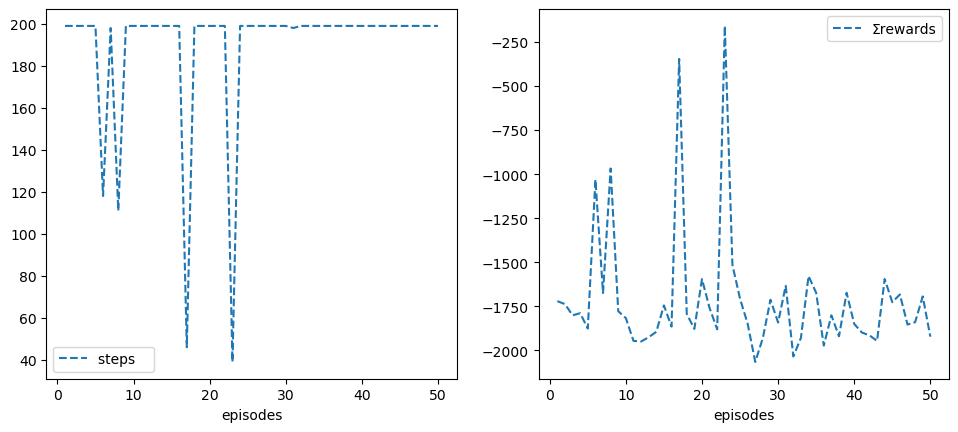

In [17]:
vsarsa = Sarsaλ(env=Env(), λ=.9, α=.3, max_t=200, episodes=50, seed=1, **demoTR()).interact()

### Attempt 2

This attempt used the same normalized laserscan state representation with 24 scans and took a total of 65 minutes to train using different hyperparameters and had a success rate of 28%

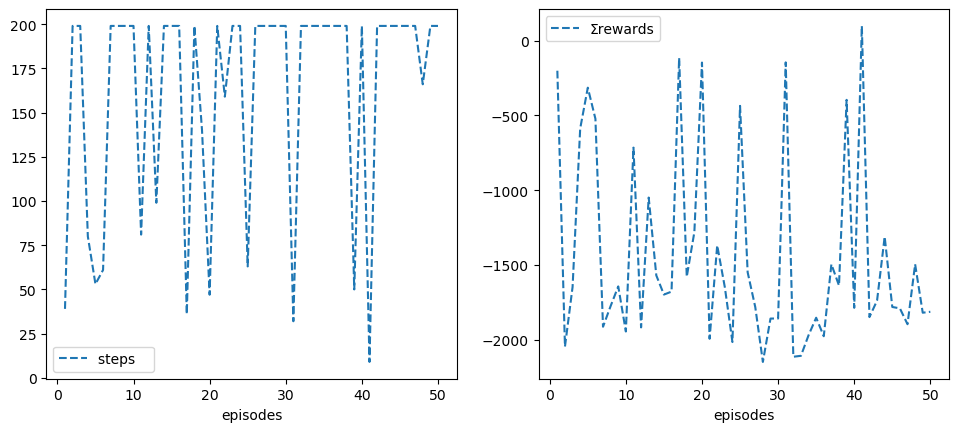

In [39]:
vsarsa = Sarsaλ(env=Env(), λ=.5, α=.3, max_t=200, episodes=50, seed=1, **demoTR()).interact()

### Attempt 3

This attempt used the raw laserscan state representation with 60 scans and took a total of 102 minutes to train and had a success rate of 52%

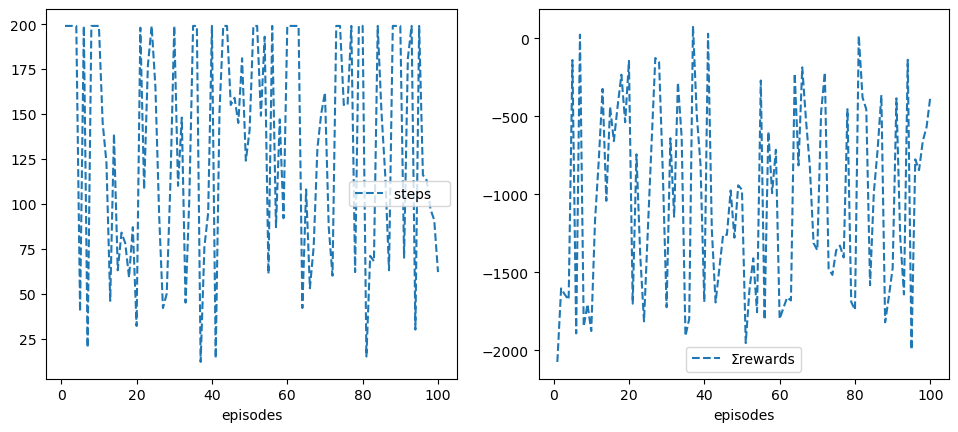

In [8]:
vsarsa = Sarsaλ(env=Env(), λ=.5, α=.3, max_t=200, episodes=100, seed=1, **demoTR()).interact()

### Attempt 4

This attempt used the buckets to discretize the laserscan state representation with 24 scans and took a total of 66 minutes to train and had a success rate of 64%

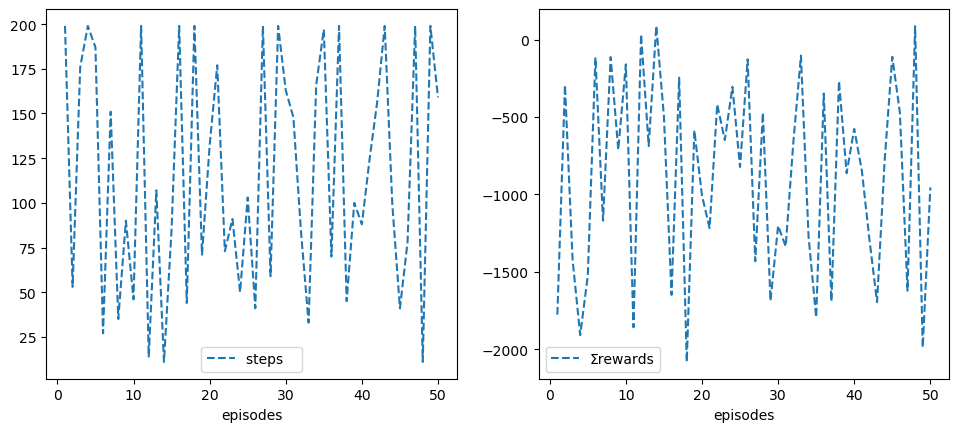

In [8]:
vsarsa = Sarsaλ(env=Env(), λ=.5, α=.3, max_t=200, episodes=50, seed=1, **demoTR()).interact()

### Attempt 5

This attempt used the buckets to discretize the laserscan state representation with 24 scans and took a total of 104 minutes to train and was trained on more episodes with different hyperparameters and had a success rate of 19%

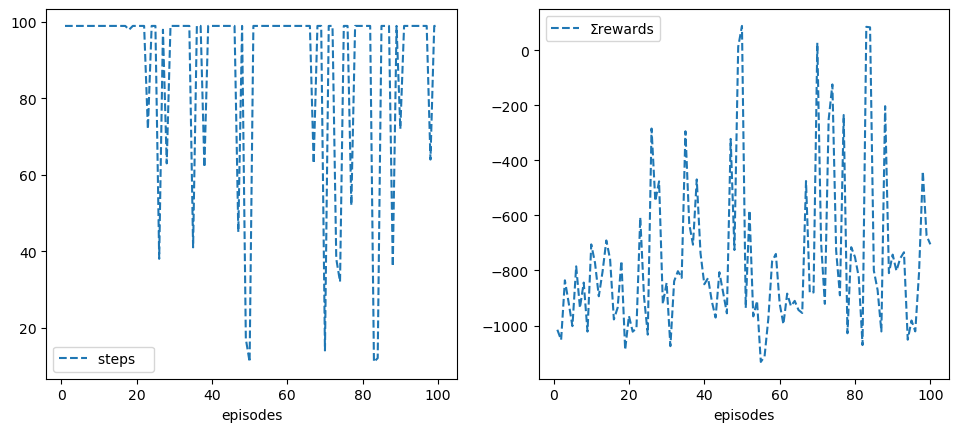

In [15]:
vsarsa = Sarsaλ(env=Env(), λ=.1, α=.1, max_t=100, episodes=100, seed=1, **demoTR()).interact()

### Attempt 6

This attempt used the buckets to discretize the laserscan state representation with 6 scans and took a total of 55 minutes to train and was trained with different hyperparameters and had a success rate of 10%

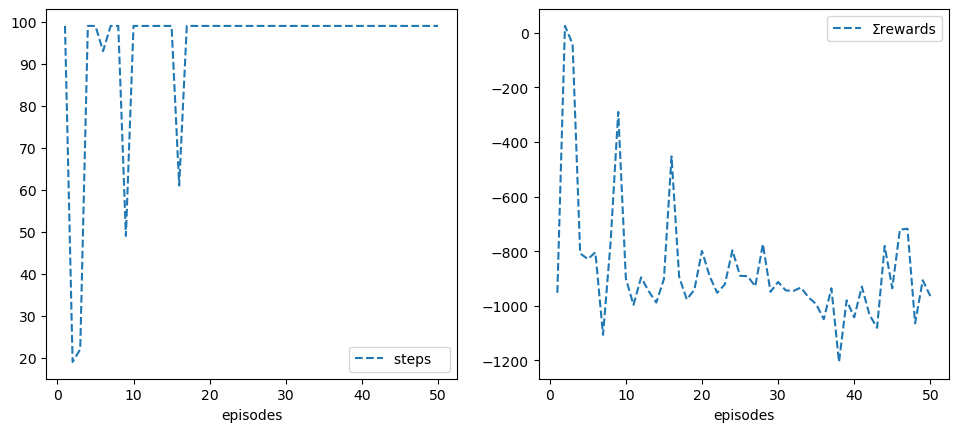

In [6]:
vsarsa = Sarsaλ(env=Env(), λ=.9, α=.1, ε=0.2, max_t=100, episodes=50, seed=1, **demoTR()).interact()

### Attempt 7

This attempt used the buckets to discretize the laserscan state representation with 6 scans and took a total of 72 minutes to train and was trained with different hyperparameters and had a success rate of 10%

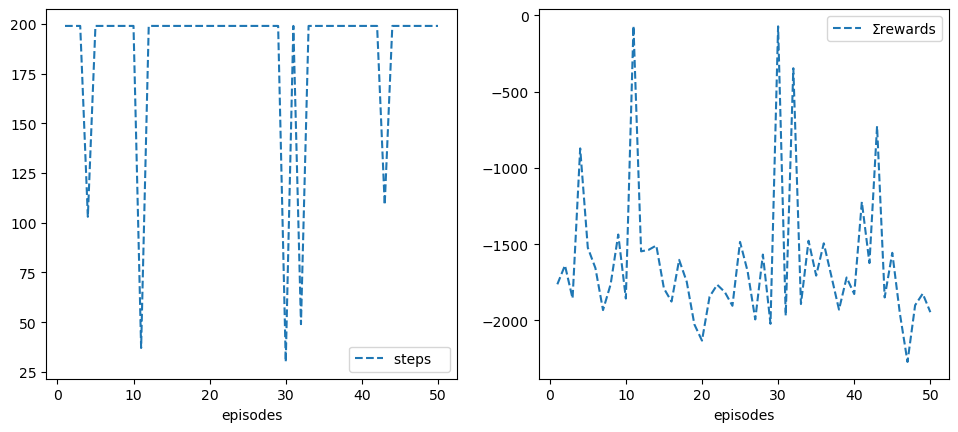

In [25]:
vsarsa = Sarsaλ(env=Env(), λ=.3, α=.8, max_t=200, episodes=50, seed=1, **demoTR()).interact()

# Parameter Tuning and Justification

The hyperparamaters I chose to try and optimize where the λ and α rates. On bucketing attempts I tried values of 0.1, 0.3, 0.5 and 0.9 for the λ values and 0.3 and 0.1 for the α values. 

I chose these hyperparameters as the lambda rate influences how far back in time the agent considers. This would allow for the agent to be tested both with testing far in the past states, and only the recent states. 

The alpha values were chosen to allow for testing more extreme learning updates vs more gradual updates which are less susceptible to noise. 

# Analyse the Model

Overall, regardless of which state representation was used, this model did not show any signs of convergence. The most successful attempt was attempt 4 using discretized buckets for 24 laserscan inputs which had a success rate of 64% using a lambda value of 0.5 and an alpha rate of 0.3. 

Despite this attempt being the most successful there was no convergence during the duration of the training as the number of steps taken to complete the episode varied greatly and there was no overall downward trend as shown in the attempt 4 figure above. 

During most of the attempts there was no trend in the total rewards. Attempt 5 showed a slightly favourable trend in the total reward per episode indicating that the robot was colliding into walls at a lesser rate over the course of the training. 

I believe this model did not converge due to the state representations attempted. Using the laser scans either normalized or raw may have meant the model had too many states to be able to correctly identify. Furthermore, using the buckets may have oversimplified the states leading to the desired action getting overwritten with a similar state needing a different action selection.

In [3]:
from RLnn import *

2024-05-01 13:42:24.762580: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 13:42:24.859665: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 13:42:24.860869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 13:42:26.559653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Model 2

For model 2 the Actor-Critic model was used for the policy gradient RL method as it allows the RL model to use a critic value function as a guide for updating the actor policy. This leads to faster learning and can also use experience replay to improve from past experiences and not only the current path that the robot is taking which can lead to better convergence. 

While attempting to train this model it was experiencing memory leaks on the virtual machine which led to the model crashing the VM after running for around 15 minutes. For this I had to decrease the maximum step size to allow for the model to be able to complete the training episode.

# Rewards

For model 2 I used the same reward function as was used in model 1 to encourage the robot to move around the environment more and to encourage the robot to repeatedly seek out the goal if the goal was successfully found in one of the episodes due to the much higher reward placed on the goal state. 

Unfortunately, in this model the goal was never reached due to the short training steps which were required to avoid the machine crashing during learning. 

# Neural Network Architecture

For the neural network it contained used 4 Dense layers as the input space was only 2 dimentional so it was not possible to use convolutional layers with the current state space representation. The final Dense layer had an output of 1 for the actor-critic model to select which action should be taken given the input space. 

In [4]:
class actor_critic_NN(PG(MDP)):
    def __init__(self, α=1e-4, **kw): 
        super().__init__(**kw)
        self.α = α
        self.store = True
        self.buffer = 1000
        self.visual = False

    def step0(self):
        self.γt = 1 # powers of γ


    def create_model(self, net_str):
        x0 = Input(self.env.reset().shape)
        x = Dense(64, activation='relu')(x0)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.nF, 'relu')(x)
        x = Dense(1 if net_str=='V' else self.env.nA)(x) 
        model = Model(x0, x)
        model.compile(Adam(self.α), loss='mse')
        model.summary() if net_str != 'Qn' else None
        model.net_str = net_str
        return model
        
    # -------------------------------------- 🌖 online learning ------------------------------
    def online(self, s, rn,sn, done, a,_): 
        print(f"Episode {self.ep}")
        print(f"Step = {self.t}")
        if len(self.buffer) < self.nbuffer: return

        # sample a tuple batch: each componenet is a batch of items 
        # (s and a are sets of states and actions)
        (s, a, rn, sn, dones), inds = self.batch()

        s = np.squeeze(s, axis=0)

        π, γ, γt, α, τ, t = self.π, self.γ, self.γt, self.α, self.τ, self.t

        Vs = self.V(s)
        Vsn = self.V(sn)

        δ = (1- done)*γ*Vsn + rn - Vs # temporal difference calculation

        Vsn = Vs + α*δ * (1 - π(s,a))*γt/τ # Actor update calculation
        Vs = Vs + α*δ # Critic update calculation

        self.γt *= γ

        s = np.expand_dims(s, axis=0)

        self.V(s, Vs) # critic update
        self.V(sn, Vsn) # actor update

In [5]:
class nnEnv(Env):
    def __init__(self, **kw): 
        super().__init__(**kw)
        self.nF = 60

    def s_(self):
        nF, scans, range_max = self.nF, self.scans, self.range_max
        φ = np.r_[scans[-nF//2:], scans[:nF//2]]
        φ[φ==Inf] = range_max
        φ = φ/φ.sum()
        return φ

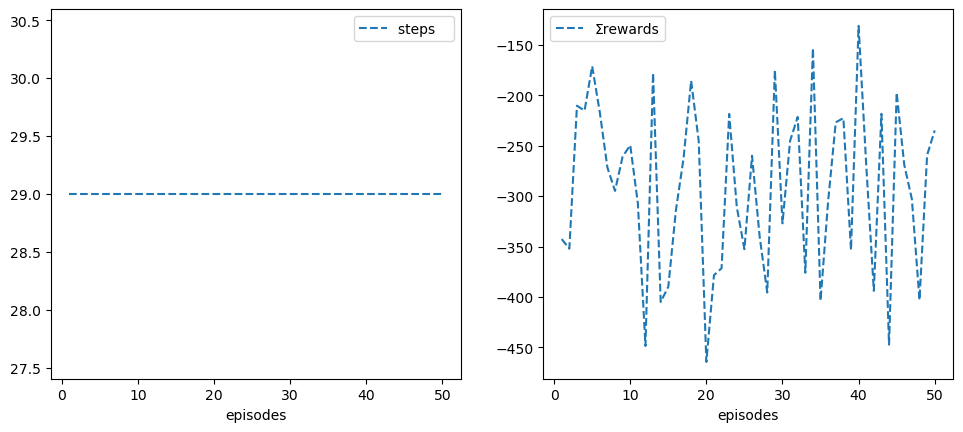

In [6]:
a_c_nn = actor_critic_NN(env=nnEnv(), load_weights=False, max_t=30, α=1, τ=.1, γ=1, episodes=50, seed=1, nbuffer=1, nbatch=1, create_vN=True, **demoTR()).interact()

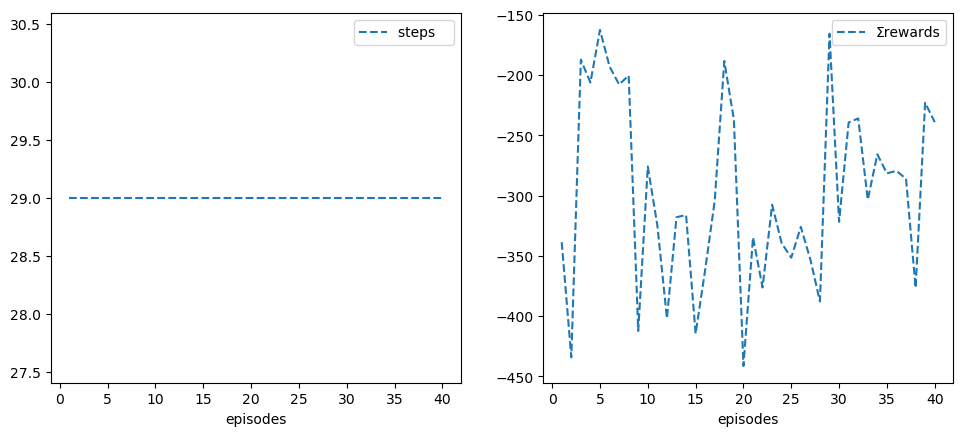

In [7]:
a_c_nn = actor_critic_NN(env=nnEnv(), load_weights=False, max_t=30, α=0.5, τ=.1, γ=0.9, episodes=40, seed=1, nbuffer=1, nbatch=1, create_vN=True, **demoTR()).interact()

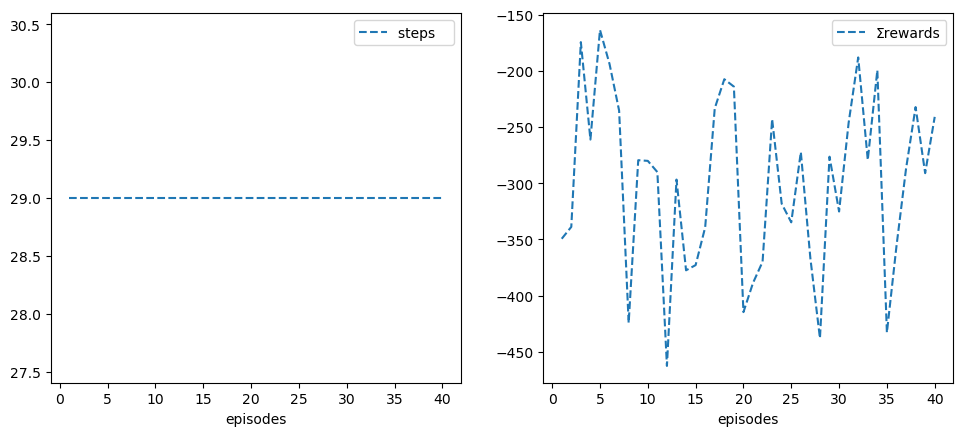

In [6]:
a_c_nn = actor_critic_NN(env=nnEnv(), load_weights=False, max_t=30, α=0.3, τ=.1, γ=0.5, episodes=40, seed=1, nbuffer=1, nbatch=1, create_vN=True, **demoTR()).interact()

# Parameter Tuning and Justification

In this model the parameters that were tuned were the alpha and gamma values. The alpha is responsible for the learning rate and how quickly the value function updates, this was chosen as higher values could speed up the convergence and lower could lead to smoother learning. 

The gamma discount factor was used to allow for different importances to be placed on both long-term and immediate rewards of the agent to examine which would be more effective during the learning. 

# Analysis of the results

During this training the model was unable to reach the goal in any of the episodes. This is likely due to the very small step size and low number of episodes used due to the memory usage of the model crashing the virtual machine after running for more than 15 minutes. Due to this the maximum amount of steps each episode was always hit and there was also no progress made from the model to avoid the collisions as seen on the reward graph showing consistent high negative reward values throughout the episodes. 

This model may have converged if it could train for longer since a larger state space was used which consisted of the laser scan inputs. Neural networks are much better at using large state spaces in order to generalise actions to similar states than other RL methods which may have led the agent to converge if a lot more training time was available.

Training this model for longer and running for a higher number of maximum steps if possible, may have shown better results as then it could have been observed of the behaviour after reaching the goal.

# Conclusion and Reflection

In conclusion, both of the RL models tested did not converge or learn to consistently find the goal when running regardless of the hyperparameters selected. In model 1 I believe this was due to the state representations used did not convey the information well enough for the agent to learn efficiently causing states to be either over generalised or too sparse. In model 2 I believe this was due to being unable to train the agent for a significant amount of time and therefore the agent not being able to explore properly. 

### What went well

The agent was moving in the environment successfully and obtaining the correct rewards for collisions and reaching the goal. Furthermore, I was able to apply different state representations to the agent even if these were not sufficient. 

### What went wrong

The agent did not improve over the course of the training even with hyperparameters changed in either model used. If I attempted this work again I would try more representations for the states and try to balance the size of the state with the information represented better. 